In [36]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Tuple, Any
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.naive_bayes import BernoulliNB

## 1. Ορισμός κλάσεων

In [37]:
class WordStat:
    """Κρατάει στατιστικά εμφάνισης λέξης σε θετικές/αρνητικές κριτικές"""
    def __init__(self):
        self.positive_count = 0  # Πλήθος εγγράφων θετικής κλάσης που περιέχουν τη λέξη
        self.negative_count = 0  # Πλήθος εγγράφων αρνητικής κλάσης που περιέχουν τη λέξη
    
    @property
    def doc_frequency(self):
        """Συνολική συχνότητα εμφάνισης σε έγγραφα"""
        return self.positive_count + self.negative_count

class VocabularyBuilder:
    """Δημιουργεί το λεξιλόγιο με βάση τα εκπαιδευτικά δεδομένα"""
    def __init__(self, positive_train_path: str, negative_train_path: str):
        self.positive_train_path = positive_train_path
        self.negative_train_path = negative_train_path
        self.vocabulary = []  # Τελικό λεξιλόγιο
    
    def run_vocabulary_process(self, n: int, k: int, m: int):
        """
        Βασική διαδικασία δημιουργίας λεξιλογίου:
        n - Αγνοούμε τις top-n πιο συχνές λέξεις
        k - Αγνοούμε τις k λιγότερο συχνές λέξεις
        m - Επιλέγουμε τις top-m λέξεις βάσει IG
        """
        print("Αρχικοποίηση δημιουργίας λεξιλογίου...")
        word_stats = defaultdict(WordStat)  # Λεξικό για στατιστικά λέξεων
        
        # Επεξεργασία θετικών εγγράφων
        print(f"Διαβάζω θετικά έγγραφα εκπαίδευσης από: {self.positive_train_path}")
        positive_files = self._get_text_files(self.positive_train_path)
        p_count = self._process_files(positive_files, word_stats, True)
        print(f"Επεξεργάστηκα {p_count} θετικά έγγραφα")
        
        # Επεξεργασία αρνητικών εγγράφων
        print(f"Διαβάζω αρνητικά έγγραφα εκπαίδευσης από: {self.negative_train_path}")
        negative_files = self._get_text_files(self.negative_train_path)
        n_count = self._process_files(negative_files, word_stats, False)
        print(f"Επεξεργάστηκα {n_count} αρνητικά έγγραφα")
        
        # Φιλτράρισμα λέξεων
        print(f"\nΦιλτράρισμα λέξεων (αγνοώ τις top {n} συχνές και τις {k} σπάνιες)...")
        filtered_words = self._filter_words(word_stats, n, k)
        print(f"Υποψήφιες λέξεις μετά το φιλτράρισμα: {len(filtered_words)}")
        
        # Υπολογισμός Information Gain
        print("\nΥπολογισμός πληροφοριακού κέρδους (IG) για υποψήφιες λέξεις...")
        ig_values = self._calculate_ig(word_stats, filtered_words, p_count, n_count)
        print("Ολοκληρώθηκε ο υπολογισμός IG")
        
        # Επιλογή τελικού λεξιλογίου
        print(f"\nΕπιλογή top {m} λέξεων με βάση το IG...")
        self.vocabulary = self._select_vocabulary(filtered_words, ig_values, m, word_stats)
        self._print_results()
    
    def _get_text_files(self, directory: str) -> List[str]:
        """Επιστρέφει λίστα με τα .txt αρχεία στον φάκελο"""
        return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
    
    def _process_files(self, files: List[str], stats: Dict[str, WordStat], is_positive: bool) -> int:
        """Επεξεργάζεται έγγραφα και ενημερώνει τα στατιστικά λέξεων"""
        for i, file in enumerate(files, 1):
            if i % 500 == 0:  # Εκτύπωση προόδου κάθε 500 αρχεία
                print(f"Επεξεργασία αρχείου {i}/{len(files)}")
            
            with open(file, 'r', encoding='utf-8') as f:
                content = f.read()
            
            # Καθαρισμός κειμένου και εξαγωγή μοναδικών λέξεων
            words = self._tokenize(content)
            
            # Ενημέρωση στατιστικών
            for word in words:
                if is_positive:
                    stats[word].positive_count += 1
                else:
                    stats[word].negative_count += 1
        return len(files)
    
    def _tokenize(self, content: str) -> set:
        """
        Καθαρισμός κειμένου και διαχωρισμός σε λέξεις:
        1. Μετατροπή σε πεζά
        2. Αφαίρεση μη αλφαβητικών χαρακτήρων (εκτός από apostrophe)
        3. Διόρθωση αποστόφων
        4. Διαχωρισμός λέξεων και αφαίρεση κενών λέξεων
        """
        cleaned = re.sub(r"[^a-z'\s]", " ", content.lower())
        cleaned = re.sub(r"\s'+ ", " ", cleaned)
        cleaned = re.sub(r"'\s+", " ", cleaned)
        return {word for word in re.split(r'\s+', cleaned) if word and not re.match(r"^'+$", word)}
    
    def _filter_words(self, stats: Dict[str, WordStat], n: int, k: int) -> List[str]:
        """Φιλτράρει λέξεις βάσει συχνότητας εμφάνισης"""
        # Ταξινόμηση λέξεων από πιο συχνές προς λιγότερο συχνές
        sorted_words = sorted(stats.keys(), key=lambda w: stats[w].doc_frequency, reverse=True)
        
        # Αγνόησε τις top-n πιο συχνές λέξεις
        filtered = sorted_words[n:] if n < len(sorted_words) else []
        
        # Ταξινόμηση από λιγότερο συχνές προς πιο συχνές
        filtered.sort(key=lambda w: stats[w].doc_frequency)
        
        # Αγνόησε τις k λιγότερο συχνές λέξεις
        return filtered[k:] if k < len(filtered) else []
    
    def _calculate_ig(self, stats: Dict[str, WordStat], candidates: List[str], total_pos: int, total_neg: int) -> List[float]:
        """Υπολογίζει το Information Gain για υποψήφιες λέξεις"""
        total_docs = total_pos + total_neg
        pc1 = total_pos / total_docs
        hc = self._two_c_entropy(pc1)  # Εντροπία κλάσης
        ig_values = []
        
        print(f"Υπολογισμός IG για {len(candidates)} λέξεις...")
        
        for i, word in enumerate(candidates, 1):
            if i % 500 == 0:  # Εκτύπωση προόδου
                print(f"Υπολογισμός IG - Λέξη {i}/{len(candidates)}")
                
            stat = stats.get(word, WordStat())
            cx1 = stat.doc_frequency  # Συχνότητα εμφάνισης λέξης
            
            if cx1 == 0:
                ig_values.append(0.0)
                continue
                
            # Υπολογισμός πιθανοτήτων
            pc1x1 = stat.positive_count / cx1  # P(κλάση=θετική|λέξη υπάρχει)
            pc1x0 = (total_pos - stat.positive_count) / (total_docs - cx1) if (total_docs - cx1) > 0 else 0
            
            # Υπολογισμός εντροπιών
            hcx1 = self._two_c_entropy(pc1x1)
            hcx0 = self._two_c_entropy(pc1x0)
            px1 = cx1 / total_docs
            
            # Τελικός IG
            ig = hc - (px1 * hcx1 + (1 - px1) * hcx0)
            ig_values.append(ig)
            
        return ig_values
    
    def _two_c_entropy(self, p: float) -> float:
        """Υπολογισμός εντροπίας για δυαδική μεταβλητή"""
        if p == 0 or p == 1:
            return 0.0
        return -p * math.log2(p) - (1 - p) * math.log2(1 - p)
    
    def _select_vocabulary(self, candidates: List[str], ig_values: List[float], m: int, stats: Dict[str, WordStat]) -> List[str]:
        """Επιλέγει τις top-m λέξεις με βάση το IG"""
        # Ταξινόμηση λέξεων βάσει IG (φθίνουσα)
        sorted_words = sorted(zip(candidates, ig_values), key=lambda x: x[1], reverse=True)
        selected = [word for word, _ in sorted_words[:m]]
        
        # Ανάλυση επιλεγμένων λέξεων
        pos_words = sum(1 for word in selected if stats[word].positive_count > stats[word].negative_count)
        neg_words = sum(1 for word in selected if stats[word].negative_count > stats[word].positive_count)
        
        print(f"Λέξεις πιο συχνές σε θετικές κριτικές: {pos_words}")
        print(f"Λέξεις πιο συχνές σε αρνητικές κριτικές: {neg_words}")
        return selected
    
    def _print_results(self):
        print(f"\nΤελικό λεξιλόγιο ({len(self.vocabulary)} λέξεις)")
        
    def get_vocabulary(self) -> List[str]:
        return self.vocabulary

class FeatureVector:
    """Δημιουργεί διανύσματα χαρακτηριστικών από έγγραφα"""
    def __init__(self, features: np.ndarray, file_name: str):
        self.features = features.astype(np.int8)  # Διάνυσμα χαρακτηριστικών
        self.file_name = file_name  # Όνομα αρχείου προέλευσης
    
    @staticmethod
    def create_feature_vectors(vocabulary: List[str], positive_path: str, negative_path: str, total_docs: int) -> List['FeatureVector']:
        """Δημιουργεί διανύσματα για όλα τα έγγραφα"""
        vectors = []
        per_class = total_docs // 2  # Έγγραφα ανά κλάση
        
        print(f"Δημιουργία διανυσμάτων για θετικές κριτικές (max {per_class})...")
        vectors.extend(FeatureVector._process_class(positive_path, vocabulary, per_class, 1))
        
        print(f"Δημιουργία διανυσμάτων για αρνητικές κριτικές (max {per_class})...")
        vectors.extend(FeatureVector._process_class(negative_path, vocabulary, per_class, 0))
        
        print(f"Δημιουργήθηκαν συνολικά {len(vectors)} διανύσματα χαρακτηριστικών")
        return vectors
    
    @staticmethod
    def _process_class(folder: str, vocabulary: List[str], max_files: int, label: int) -> List['FeatureVector']:
        """Δημιουργεί διανύσματα για έγγραφα μιας κλάσης"""
        vectors = []
        files = [f for f in os.listdir(folder) if f.endswith('.txt')][:max_files]
        
        print(f"Επεξεργασία {len(files)} αρχείων από {folder}")
        
        for i, file_name in enumerate(files, 1):
            if i % 500 == 0:
                print(f"Επεξεργασία αρχείου {i}/{len(files)}")
                
            with open(os.path.join(folder, file_name), 'r', encoding='utf-8') as f:
                content = f.read().lower()  # Μετατροπή σε πεζά
            
            # Δημιουργία διανύσματος: 1 αν η λέξη υπάρχει, 0 διαφορετικά
            features = [1 if word in content else 0 for word in vocabulary]
            features.append(label)  # Προσθήκη ετικέτας
            vectors.append(FeatureVector(np.array(features), file_name))
        return vectors

class NaiveBayes:
    """Υλοποίηση Naive Bayes ταξινομητή"""
    def __init__(self, num_features: int):
        self.num_features = num_features
        self.log_prior = None  # Log πιθανότητες κλάσεων
        self.log_likelihood_1 = None  # Log P(x_i=1|y)
        self.log_likelihood_0 = None  # Log P(x_i=0|y)
    
    def train(self, training_data: List[FeatureVector]):
        """Εκπαίδευση μοντέλου"""
        print("Έναρξη εκπαίδευσης Naive Bayes...")
        
        class_counts = np.zeros(2, dtype=int)  # Πλήθος εγγράφων ανά κλάση
        feature_counts = np.zeros((2, self.num_features), dtype=int)  # Πλήθος εμφάνισης χαρακτηριστικών ανά κλάση
        
        # Σάρωση όλων των διανυσμάτων εκπαίδευσης
        for fv in training_data:
            features = fv.features[:-1]  # Χαρακτηριστικά
            label = int(fv.features[-1])  # Ετικέτα
            class_counts[label] += 1
            feature_counts[label] += features  # Αθροίζουμε τα διανύσματα
        
        total_docs = class_counts.sum()
        self.log_prior = np.log(class_counts / total_docs)  # Log prior πιθανότητες
        
        # Εφαρμογή Laplace smoothing
        alpha = 1.0
        smoothed_num = feature_counts + alpha
        smoothed_denom = class_counts[:, np.newaxis] + 2 * alpha
        
        # Υπολογισμός log πιθανοτήτων
        self.log_likelihood_1 = np.log(smoothed_num / smoothed_denom)  # P(x_i=1|y)
        self.log_likelihood_0 = np.log(1 - np.exp(self.log_likelihood_1))  # P(x_i=0|y)
        
        print("Ολοκληρώθηκε η εκπαίδευση")
    
    def predict(self, features: np.ndarray) -> int:
        """Πρόβλεψη κλάσης για νέο διάνυσμα"""
        log_scores = self.log_prior.copy()  # Αρχικοποίηση με log prior
        features = np.array(features, dtype=int)
        
        # Υπολογισμός log πιθανότητας για κάθε κλάση
        for i in range(2):
            # Όροι για χαρακτηριστικά που υπάρχουν (1)
            term1 = np.sum(features * self.log_likelihood_1[i])
            # Όροι για χαρακτηριστικά που απουσιάζουν (0)
            term2 = np.sum((1 - features) * self.log_likelihood_0[i])
            log_scores[i] += term1 + term2
            
        return np.argmax(log_scores)  # Επιστροφή κλάσης με υψηλότερη πιθανότητα

## 2. Δημιουργία λεξιλογίου

In [38]:
print("="*70)
print("ΣΤΑΔΙΟ 1: ΔΗΜΙΟΥΡΓΙΑ ΛΕΞΙΛΟΓΙΟΥ")
print("="*70)

# Δημιουργία λεξιλογίου
vb = VocabularyBuilder("aclImdb/train/pos/", "aclImdb/train/neg/")
vb.run_vocabulary_process(n=50, k=80, m=500)
vocabulary = vb.get_vocabulary()
print(f"Πρώτες 10 λέξεις λεξιλογίου: {vocabulary[:10]}")

ΣΤΑΔΙΟ 1: ΔΗΜΙΟΥΡΓΙΑ ΛΕΞΙΛΟΓΙΟΥ
Αρχικοποίηση δημιουργίας λεξιλογίου...
Διαβάζω θετικά έγγραφα εκπαίδευσης από: aclImdb/train/pos/
Επεξεργασία αρχείου 500/12500
Επεξεργασία αρχείου 1000/12500
Επεξεργασία αρχείου 1500/12500
Επεξεργασία αρχείου 2000/12500
Επεξεργασία αρχείου 2500/12500
Επεξεργασία αρχείου 3000/12500
Επεξεργασία αρχείου 3500/12500
Επεξεργασία αρχείου 4000/12500
Επεξεργασία αρχείου 4500/12500
Επεξεργασία αρχείου 5000/12500
Επεξεργασία αρχείου 5500/12500
Επεξεργασία αρχείου 6000/12500
Επεξεργασία αρχείου 6500/12500
Επεξεργασία αρχείου 7000/12500
Επεξεργασία αρχείου 7500/12500
Επεξεργασία αρχείου 8000/12500
Επεξεργασία αρχείου 8500/12500
Επεξεργασία αρχείου 9000/12500
Επεξεργασία αρχείου 9500/12500
Επεξεργασία αρχείου 10000/12500
Επεξεργασία αρχείου 10500/12500
Επεξεργασία αρχείου 11000/12500
Επεξεργασία αρχείου 11500/12500
Επεξεργασία αρχείου 12000/12500
Επεξεργασία αρχείου 12500/12500
Επεξεργάστηκα 12500 θετικά έγγραφα
Διαβάζω αρνητικά έγγραφα εκπαίδευσης από: aclImdb/train

## 3. Δημιουργία διανυσμάτων χαρακτηριστικών

In [39]:
print("\n" + "="*70)
print("ΣΤΑΔΙΟ 2: ΔΗΜΙΟΥΡΓΙΑ ΔΙΑΝΥΣΜΑΤΩΝ ΧΑΡΑΚΤΗΡΙΣΤΙΚΩΝ")
print("="*70)

# Διανύσματα εκπαίδευσης
print("\nΔημιουργία διανυσμάτων εκπαίδευσης...")
train_vectors = FeatureVector.create_feature_vectors(
    vocabulary, 
    "aclImdb/train/pos/", 
    "aclImdb/train/neg/", 
    25000
)
random.shuffle(train_vectors)  # Ανακάτεμα για καλύτερη εκπαίδευση

# Διανύσματα ελέγχου
print("\nΔημιουργία διανυσμάτων ελέγχου...")
test_vectors = FeatureVector.create_feature_vectors(
    vocabulary, 
    "aclImdb/test/pos/", 
    "aclImdb/test/neg/", 
    25000
)

print(f"Σύνολο διανυσμάτων εκπαίδευσης: {len(train_vectors)}")
print(f"Σύνολο διανυσμάτων ελέγχου: {len(test_vectors)}")


ΣΤΑΔΙΟ 2: ΔΗΜΙΟΥΡΓΙΑ ΔΙΑΝΥΣΜΑΤΩΝ ΧΑΡΑΚΤΗΡΙΣΤΙΚΩΝ

Δημιουργία διανυσμάτων εκπαίδευσης...
Δημιουργία διανυσμάτων για θετικές κριτικές (max 12500)...
Επεξεργασία 12500 αρχείων από aclImdb/train/pos/
Επεξεργασία αρχείου 500/12500
Επεξεργασία αρχείου 1000/12500
Επεξεργασία αρχείου 1500/12500
Επεξεργασία αρχείου 2000/12500
Επεξεργασία αρχείου 2500/12500
Επεξεργασία αρχείου 3000/12500
Επεξεργασία αρχείου 3500/12500
Επεξεργασία αρχείου 4000/12500
Επεξεργασία αρχείου 4500/12500
Επεξεργασία αρχείου 5000/12500
Επεξεργασία αρχείου 5500/12500
Επεξεργασία αρχείου 6000/12500
Επεξεργασία αρχείου 6500/12500
Επεξεργασία αρχείου 7000/12500
Επεξεργασία αρχείου 7500/12500
Επεξεργασία αρχείου 8000/12500
Επεξεργασία αρχείου 8500/12500
Επεξεργασία αρχείου 9000/12500
Επεξεργασία αρχείου 9500/12500
Επεξεργασία αρχείου 10000/12500
Επεξεργασία αρχείου 10500/12500
Επεξεργασία αρχείου 11000/12500
Επεξεργασία αρχείου 11500/12500
Επεξεργασία αρχείου 12000/12500
Επεξεργασία αρχείου 12500/12500
Δημιουργία διανυσμάτων 

## 4. Εκπαίδευση και αξιολόγηση

In [40]:
def evaluate_model(model, vectors, model_name: str):
    """Αξιολόγηση μοντέλου και εκτύπωση μετρικών"""
    print(f"\nΑξιολόγηση μοντέλου '{model_name}'...")
    
    X = [fv.features[:-1] for fv in vectors]
    y_true = [fv.features[-1] for fv in vectors]
    
    # Πρόβλεψη ετικετών
    print("Πραγματοποιώ προβλέψεις...")
    y_pred = [model.predict(x) for x in X]
    
    # Εκτύπωση μετρικών
    print("\nΑποτελέσματα Ταξινόμησης:")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
    print(f"Accuracy: {np.mean(np.array(y_true) == np.array(y_pred)):.4f}")

print("\n" + "="*70)
print("ΣΤΑΔΙΟ 3: ΕΚΠΑΙΔΕΥΣΗ ΚΑΙ ΑΞΙΟΛΟΓΗΣΗ")
print("="*70)

# Εκπαίδευση custom μοντέλου
print("\nΕκπαίδευση Custom NaiveBayes...")
custom_nb = NaiveBayes(len(vocabulary))
custom_nb.train(train_vectors)

# Αξιολόγηση custom μοντέλου
evaluate_model(custom_nb, test_vectors, "Custom NaiveBayes")

# Εκπαίδευση scikit-learn μοντέλου
print("\nΕκπαίδευση Scikit-Learn NaiveBayes...")
sk_nb = BernoulliNB()
X_train = [fv.features[:-1] for fv in train_vectors]
y_train = [fv.features[-1] for fv in train_vectors]
sk_nb.fit(X_train, y_train)

# Αξιολόγηση scikit-learn μοντέλου
X_test = [fv.features[:-1] for fv in test_vectors]
y_test = [fv.features[-1] for fv in test_vectors]
y_pred_sk = sk_nb.predict(X_test)

print("\nΑποτελέσματα Scikit-Learn NaiveBayes:")
print(classification_report(y_test, y_pred_sk, target_names=['Negative', 'Positive']))
print(f"Accuracy: {accuracy_score(y_test, y_pred_sk):.4f}")


ΣΤΑΔΙΟ 3: ΕΚΠΑΙΔΕΥΣΗ ΚΑΙ ΑΞΙΟΛΟΓΗΣΗ

Εκπαίδευση Custom NaiveBayes...
Έναρξη εκπαίδευσης Naive Bayes...
Ολοκληρώθηκε η εκπαίδευση

Αξιολόγηση μοντέλου 'Custom NaiveBayes'...
Πραγματοποιώ προβλέψεις...

Αποτελέσματα Ταξινόμησης:
              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84     12500
    Positive       0.83      0.86      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy: 0.8431

Εκπαίδευση Scikit-Learn NaiveBayes...

Αποτελέσματα Scikit-Learn NaiveBayes:
              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84     12500
    Positive       0.83      0.86      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy: 0.8431


## 5. Σύγκριση μετρικών


ΣΤΑΔΙΟ 4: ΚΑΜΠΥΛΕΣ ΜΑΘΗΣΗΣ
Υπολογισμός καμπυλών μάθησης...

Προσαρμογή για 500 παραδείγματα (1/7)
  Custom NB - Εκπαίδευση...
Έναρξη εκπαίδευσης Naive Bayes...
Ολοκληρώθηκε η εκπαίδευση
  Custom NB - Πρόβλεψη σε train set...
  Custom NB - Πρόβλεψη σε test set...
  Scikit-Learn NB - Εκπαίδευση...
  Scikit-Learn NB - Πρόβλεψη...

Προσαρμογή για 1000 παραδείγματα (2/7)
  Custom NB - Εκπαίδευση...
Έναρξη εκπαίδευσης Naive Bayes...
Ολοκληρώθηκε η εκπαίδευση
  Custom NB - Πρόβλεψη σε train set...
  Custom NB - Πρόβλεψη σε test set...
  Scikit-Learn NB - Εκπαίδευση...
  Scikit-Learn NB - Πρόβλεψη...

Προσαρμογή για 5000 παραδείγματα (3/7)
  Custom NB - Εκπαίδευση...
Έναρξη εκπαίδευσης Naive Bayes...
Ολοκληρώθηκε η εκπαίδευση
  Custom NB - Πρόβλεψη σε train set...
  Custom NB - Πρόβλεψη σε test set...
  Scikit-Learn NB - Εκπαίδευση...
  Scikit-Learn NB - Πρόβλεψη...

Προσαρμογή για 10000 παραδείγματα (4/7)
  Custom NB - Εκπαίδευση...
Έναρξη εκπαίδευσης Naive Bayes...
Ολοκληρώθηκε η εκπαίδευση

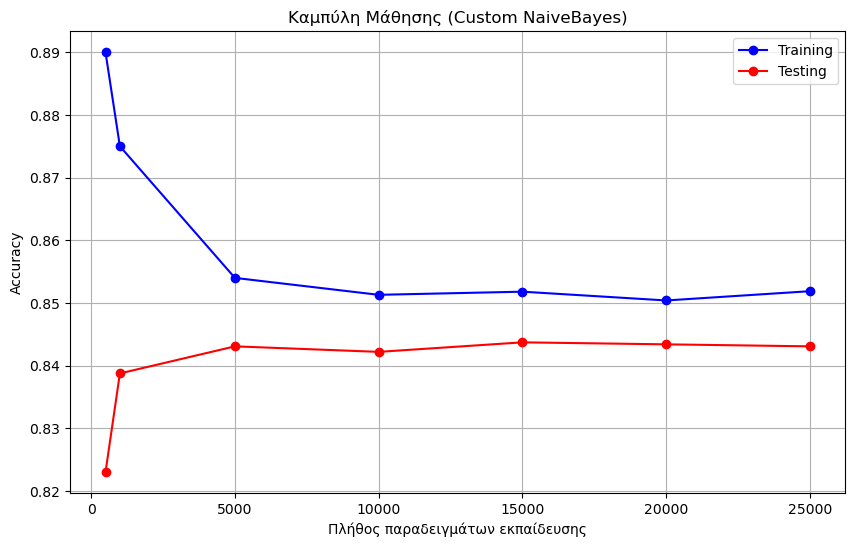

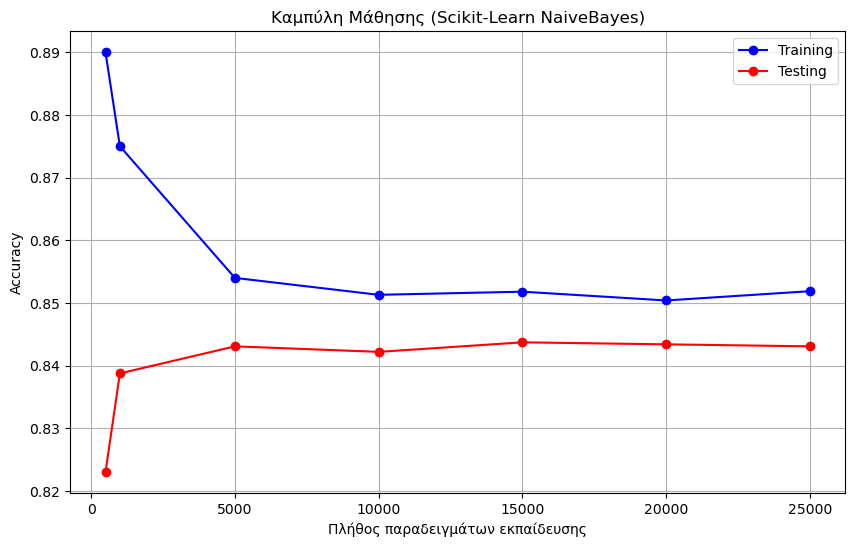

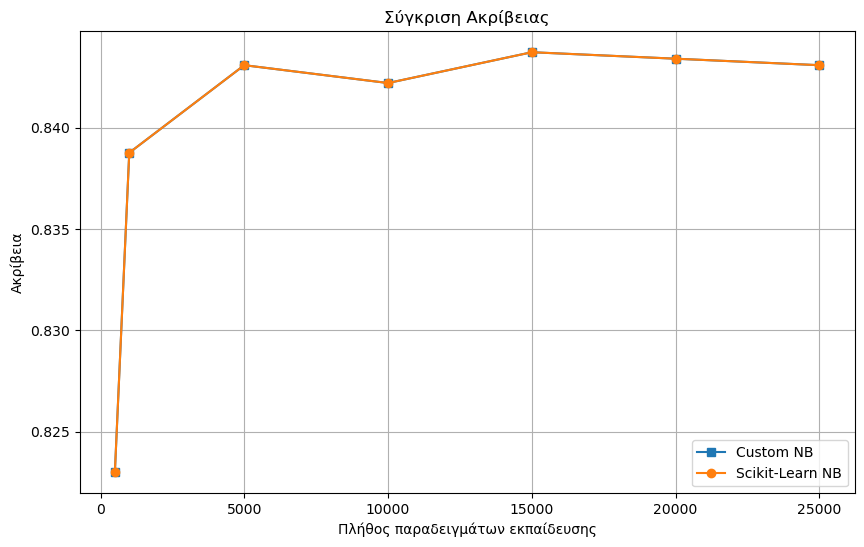

In [41]:
def plot_learning_curve(sizes, train_scores, test_scores, title):
    """Σχεδιάζει την καμπύλη μάθησης"""
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, train_scores, 'o-', color='b', label='Training')
    plt.plot(sizes, test_scores, 'o-', color='r', label='Testing')
    plt.title(title)
    plt.xlabel('Πλήθος παραδειγμάτων εκπαίδευσης')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n" + "="*70)
print("ΣΤΑΔΙΟ 4: ΚΑΜΠΥΛΕΣ ΜΑΘΗΣΗΣ")
print("="*70)

# Διαγράμματα μάθησης
training_sizes = [500, 1000, 5000, 10000, 15000, 20000, 25000]
custom_train_acc = []
custom_test_acc = []
sk_train_acc = []
sk_test_acc = []

print("Υπολογισμός καμπυλών μάθησης...")
for i, size in enumerate(training_sizes):
    print(f"\nΠροσαρμογή για {size} παραδείγματα ({i+1}/{len(training_sizes)})")
    
    # Custom NaiveBayes
    print("  Custom NB - Εκπαίδευση...")
    model = NaiveBayes(len(vocabulary))
    subset = train_vectors[:size]
    model.train(subset)
    
    # Training accuracy
    print("  Custom NB - Πρόβλεψη σε train set...")
    train_preds = [model.predict(fv.features[:-1]) for fv in subset]
    train_labels = [fv.features[-1] for fv in subset]
    custom_train_acc.append(np.mean(np.array(train_preds) == np.array(train_labels)))
    
    # Test accuracy
    print("  Custom NB - Πρόβλεψη σε test set...")
    test_preds = [model.predict(fv.features[:-1]) for fv in test_vectors]
    test_labels = [fv.features[-1] for fv in test_vectors]
    custom_test_acc.append(np.mean(np.array(test_preds) == np.array(test_labels)))
    
    # Scikit-Learn NaiveBayes
    print("  Scikit-Learn NB - Εκπαίδευση...")
    X_subset = [fv.features[:-1] for fv in subset]
    y_subset = [fv.features[-1] for fv in subset]
    sk_model = BernoulliNB()
    sk_model.fit(X_subset, y_subset)
    
    print("  Scikit-Learn NB - Πρόβλεψη...")
    sk_train_acc.append(sk_model.score(X_subset, y_subset))
    sk_test_acc.append(sk_model.score(X_test, y_test))

# Σχεδίαση διαγραμμάτων
print("\nΣχεδίαση καμπυλών μάθησης...")
plot_learning_curve(training_sizes, custom_train_acc, custom_test_acc, 
                   'Καμπύλη Μάθησης (Custom NaiveBayes)')
plot_learning_curve(training_sizes, sk_train_acc, sk_test_acc, 
                   'Καμπύλη Μάθησης (Scikit-Learn NaiveBayes)')

# Σύγκριση τελικών αποτελεσμάτων
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, custom_test_acc, 's-', label='Custom NB')
plt.plot(training_sizes, sk_test_acc, 'o-', label='Scikit-Learn NB')
plt.title('Σύγκριση Ακρίβειας')
plt.xlabel('Πλήθος παραδειγμάτων εκπαίδευσης')
plt.ylabel('Ακρίβεια')
plt.legend()
plt.grid(True)
plt.show()

## 6. Ανάλυση σημαντικών λέξεων

In [42]:
def analyze_important_words(model, vocabulary, top_n=20):
    """Ανάλυση σημαντικότητας λέξεων"""
    print(f"\nΑνάλυση top {top_n} σημαντικών λέξεων...")
    
    # Υπολογισμός λόγου πιθανοφάνειας (log(P(w|θετική)/P(w|αρνητική))
    log_ratios = model.log_likelihood_1[1] - model.log_likelihood_1[0]
    
    # Θετικές λέξεις (υψηλότερος λόγος)
    positive_indices = np.argsort(log_ratios)[::-1][:top_n]
    positive_words = [(vocabulary[i], log_ratios[i]) for i in positive_indices]
    
    # Αρνητικές λέξεις (χαμηλότερος λόγος)
    negative_indices = np.argsort(log_ratios)[:top_n]
    negative_words = [(vocabulary[i], log_ratios[i]) for i in negative_indices]
    
    # Εμφάνιση αποτελεσμάτων
    print("\nTop θετικές λέξεις (υψηλός λόγος πιθανοφάνειας):")
    for word, score in positive_words:
        print(f"{word}: {score:.4f}")
    
    print("\nTop αρνητικές λέξεις (χαμηλός λόγος πιθανοφάνειας):")
    for word, score in negative_words:
        print(f"{word}: {score:.4f}")

print("\n" + "="*70)
print("ΣΤΑΔΙΟ 5: ΑΝΑΛΥΣΗ ΛΕΞΕΩΝ")
print("="*70)

# Ανάλυση λέξεων
analyze_important_words(custom_nb, vocabulary)


ΣΤΑΔΙΟ 5: ΑΝΑΛΥΣΗ ΛΕΞΕΩΝ

Ανάλυση top 20 σημαντικών λέξεων...

Top θετικές λέξεις (υψηλός λόγος πιθανοφάνειας):
excellently: 2.9789
matthau: 2.3671
superbly: 2.3116
flawless: 2.2588
heartbreaking: 2.0794
captures: 2.0314
wonderfully: 2.0131
perfection: 1.9315
refreshing: 1.9305
delightful: 1.8971
breathtaking: 1.7789
powell: 1.7693
beautifully: 1.7584
underrated: 1.7466
gripping: 1.6767
sadness: 1.6635
touching: 1.6582
superb: 1.6506
favorites: 1.6161
marvelous: 1.6161

Top αρνητικές λέξεις (χαμηλός λόγος πιθανοφάνειας):
unwatchable: -2.9857
uwe: -2.9618
incoherent: -2.9216
stinker: -2.7636
dreck: -2.7344
unfunny: -2.6165
flimsy: -2.5649
yawn: -2.3749
horrid: -2.3514
pointless: -2.3184
redeeming: -2.2991
atrocious: -2.2300
blah: -2.2246
drivel: -2.2156
laughable: -2.2000
worst: -2.1928
wasting: -2.1253
waste: -2.1243
remotely: -2.1163
poorly: -2.0974
